In [1]:
from py2neo import Graph, Relationship, NodeSelector, authenticate
import pandas as pd
import os

In [2]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import forceatlas2_layout, random_layout
from datashader.bundling import connect_edges, hammer_bundle

from datashader.utils import export_image

In [3]:
## log in to Neo4j

f = open('neo4j-creds.txt', 'r')

creds = f.readlines()
username = creds[0].rstrip()
password = creds[1].rstrip()

authenticate("localhost:7474", username, password)
graph = Graph("http://localhost:7474/db/data/")

In [4]:
# set up dataframes
nodes_df = pd.DataFrame(columns=['id', 'title', 'sesh'])
nodes_df.set_index('id', inplace=True)

edges_df = pd.DataFrame(columns=['source', 'target'])


In [5]:
## Get all nodes
node_query = '''
            MATCH (a)-[r]->(b)
            RETURN a, b, ID(a), ID(b), r.sesh_id
            '''

node_results = graph.run(node_query)
#node_results.next()

In [6]:
for nodes in node_results:
    a = {"id": nodes['ID(a)'], "props": nodes['a'], "sesh": nodes['r.sesh_id']}
    b = {"id": nodes['ID(b)'], "props": nodes['b'], "sesh": nodes['r.sesh_id']}
    n = [a,b]
    
    for node in n:
        label = list(node['props'].labels())[0]
        title = node['props']['title'] 
        nodes_df.loc[int(node['id'])] = {"title": title, "sesh":node["sesh"]}

nodes_df.sesh = nodes_df.sesh.astype('category')

In [7]:
nodes_df.head()

title                 sesh
id                                                                         
746       I DISOWNED MY DAUGHTER TO BE WITH MY HUSBAND  2018-08-01 12:19:20
0    Dr. Phil Reunites a Mother with the Son She Lo...  2018-08-01 12:19:20
1    Dr. Phil Drops a Bombshell on Young Parents in...  2018-08-01 12:19:20
2    Dr. Phil Takes His Guest to Task for Her Behavior  2018-08-01 12:19:20
3    Dr. Phil Doesn't Mince Words about the Risks T...  2018-08-01 12:19:20

In [8]:
# get links

link_query = '''
        MATCH (a)-[r]-(b)
        RETURN ID(a), ID(b), r.sesh_id
        '''

link_results = graph.run(link_query)

for l in link_results:
    a = int(l["ID(a)"])
    b = int(l["ID(b)"])
    s = l["r.sesh_id"]

    if ((edges_df['source'] == a) & (edges_df['target'] == b)).any() == False:
        edges_df.loc[len(edges_df)] = {"source": a, "target": b} # add"sesh": s as category
        
#edges_df.sesh = edges_df.sesh.astype('category')
edges_df = edges_df.apply(pd.to_numeric)

In [9]:
edges_df.dtypes

source    int64
target    int64
dtype: object

In [10]:
# Datashader

nodes = nodes_df
edges = edges_df
print(len(nodes), "Nodes")
print(len(edges), "Edges")

cvsopts = dict(plot_height=1000, plot_width=1000)

def my_nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#333333"], color_key=colors, min_alpha=255), px=3, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)

def my_graphplot(nodes, edges, name="", canvas=None, cat=None, margin=0.05):
    if canvas is None:
        xr = nodes.x.min() - margin, nodes.x.max() + margin
        yr = nodes.y.min() - margin, nodes.y.max() + margin
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)

    np = my_nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

5035 Nodes
13556 Edges


In [11]:
# generate a color-map dict
# {"session timestamp": random hex color}

import random

colors = {}

for sesh in nodes_df.sesh.unique():
    r = lambda: random.randint(0,255)
    colors[sesh] = '#%02X%02X%02X' % (r(),r(),r())
    

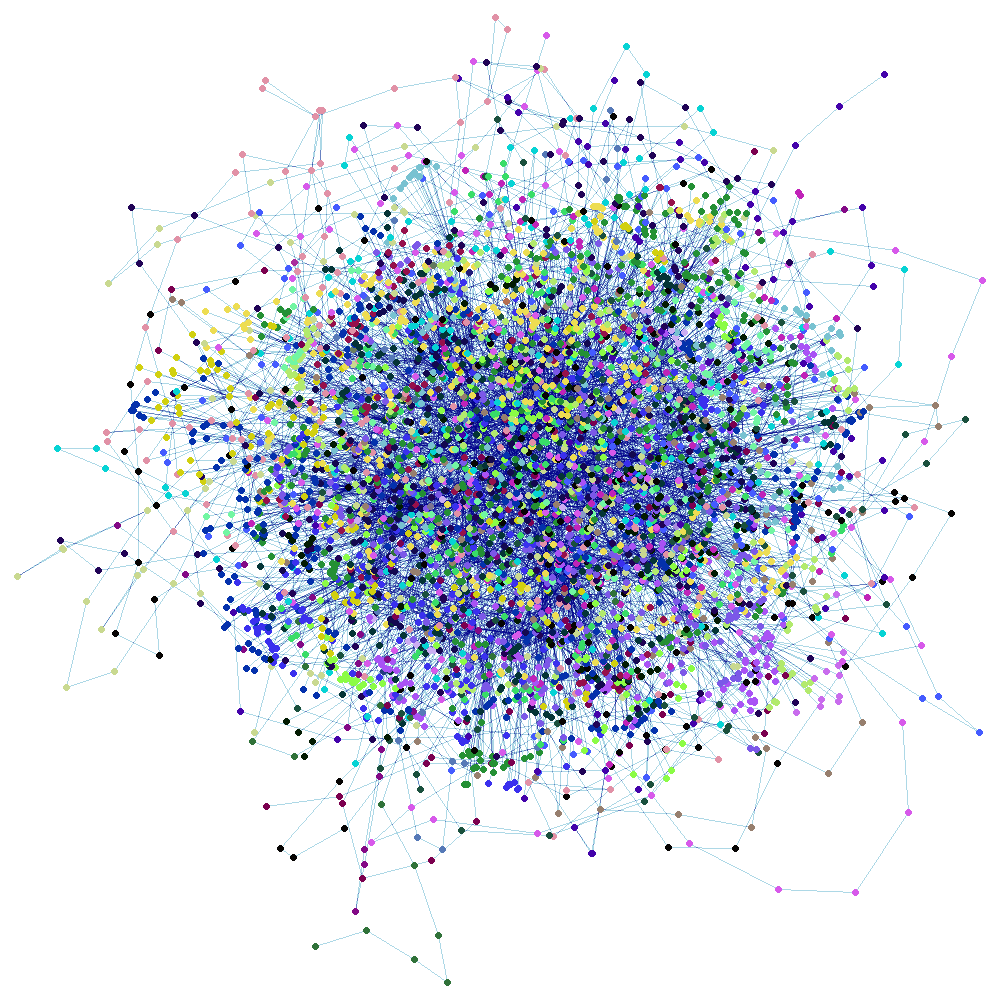

In [14]:
forcedirected = forceatlas2_layout(nodes, edges)
fd = forcedirected
tf.Image(my_graphplot(fd, connect_edges(fd,edges), "Force-directed", cat="sesh", margin=0.02))

# random layout
# randomloc = random_layout(nodes)
# tf.Image(my_graphplot(randomloc, connect_edges(randomloc,edges), "Force-directed", cat="sesh", margin=0.02))

